[```angr```](https://docs.angr.io/) is a multi-architecture binary analysis toolkit, with the capability to perform dynamic symbolic execution (like Mayhem, KLEE, etc.) and various static analyses on binaries.

In [1]:
!pip install angr
!pip install monkeyhex
!pip install bingraphvis
!pip install angr-utils
!pip install cfg-explorer

     |████████████████████████████████| 1.5 MB 406 kB/s 
     |████████████████████████████████| 178 kB 3.3 MB/s 
     |████████████████████████████████| 2.1 MB 3.3 MB/s 
     |████████████████████████████████| 153 kB 3.9 MB/s 
     |████████████████████████████████| 56 kB 2.2 MB/s 
     |████████████████████████████████| 54 kB 1.6 MB/s 
     |████████████████████████████████| 8.1 MB 5.2 MB/s 
     |████████████████████████████████| 2.9 MB 6.8 MB/s 
     |████████████████████████████████| 145 kB 7.7 MB/s 
     |████████████████████████████████| 68 kB 3.9 MB/s 
     |████████████████████████████████| 317 kB 7.8 MB/s 
     |████████████████████████████████| 32.6 MB 11.3 MB/s 
     |████████████████████████████████| 151 kB 24.4 MB/s 
     |████████████████████████████████| 66 kB 3.0 MB/s 
     |████████████████████████████████| 195 kB 23.8 MB/s 
     |████████████████████████████████| 49 kB 4.0 MB/s 
     |████████████████████████████████| 116 kB 21.3 MB/s 
  Created wheel for bitstring: 

In [2]:
import angr
import bingraphvis
from angrutils import *
from cfgexplorer import cfg_explore
import monkeyhex # this will format numerical results in hexadecimal
from PIL import Image
from IPython.core.display import SVG

/opt/conda/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /opt/conda/lib/python3.7/site-packages/pysmt/smtlib/parser/parser.py
  tree = Parsing.p_module(s, pxd, full_module_name)


In [3]:
proj = angr.Project('/bin/true')

First action with angr will always be to load a binary into a project.

A project is your control base in angr. With it, you will be able to dispatch analyses and simulations on the executable you just loaded. Almost every single object you work with in angr will depend on the existence of a project in some form.

```angr``` uses the standard logging module for logging, with every package and submodule creating a new logger.

The simplest way to get debug output is the following:

In [4]:
# import logging
# logging.getLogger('angr').setLevel('DEBUG')

### Basic Properties

In [5]:
# cpu architecture
print(proj.arch)
print(proj.arch.bits)
# print(proj.arch.bytes)
print(proj.arch.name)
print(proj.arch.memory_endness)

<Arch AMD64 (LE)>
64
AMD64
Iend_LE


In [6]:
proj.entry, proj.filename

(0x4017b0, '/bin/true')

### Loader

Getting from a binary file to its representation in a virtual address space is pretty complicated! ```angr``` a module called CLE to handle that. CLE's result, called the loader, is available in the ```.loader``` property. We can use it to see the shared libraries that angr loaded alongside our program and perform basic queries about the loaded address space.

In [7]:
print(proj.loader)
print(proj.loader.shared_objects)

print(proj.loader.min_addr)
print(proj.loader.max_addr)

print(proj.loader.main_object)            # we've loaded several binaries into this project. Here's the main one!
print(proj.loader.main_object.execstack)  # sample query: does this binary have an executable stack?
print(proj.loader.main_object.pic)        # sample query: is this binary position-independent?

<Loaded true, maps [0x400000:0x1007fff]>
OrderedDict([('true', <ELF Object true, maps [0x400000:0x60721f]>), ('libc.so.6', <ELF Object libc-2.27.so, maps [0x700000:0xaf0adf]>), ('ld-linux-x86-64.so.2', <ELF Object ld-2.27.so, maps [0xb00000:0xd2b16f]>), ('extern-address space', <ExternObject Object cle##externs, maps [0xe00000:0xe7ffff]>), ('cle##tls', <ELFTLSObjectV2 Object cle##tls, maps [0xf00000:0xf1500f]>)])
4194304
16809983
<ELF Object true, maps [0x400000:0x60721f]>
False
True


### The Factory

There are a lot of classes in angr, and most of them require a project to be instantiated. Instead of passing around the project everywhere, ```angr``` provides ```project.factory```, which has several convenient constructors for common objects we will use frequently.

In [8]:
proj.factory?

#### Blocks

```project.factory.block()``` is used to extract a basic block of code from a given address. This is an important fact - *angr analyzes code in units of basic blocks*. This will return a Block object, which can tell lots of fun things about the block of code.

In [9]:
block = proj.factory.block(proj.entry)     # lift a block of code from the program's entry point

print(block.pp())                          # pretty-print a disassembly to stdout

print(block.instructions)                  # how many instructions are there?
print(block.instruction_addrs)             # what are the addresses of the instructions?

0x4017b0:	xor	ebp, ebp
0x4017b2:	mov	r9, rdx
0x4017b5:	pop	rsi
0x4017b6:	mov	rdx, rsp
0x4017b9:	and	rsp, 0xfffffffffffffff0
0x4017bd:	push	rax
0x4017be:	push	rsp
0x4017bf:	lea	r8, [rip + 0x322a]
0x4017c6:	lea	rcx, [rip + 0x31b3]
0x4017cd:	lea	rdi, [rip - 0xe4]
0x4017d4:	call	qword ptr [rip + 0x2057fe]
None
11
[4200368, 4200370, 4200373, 4200374, 4200377, 4200381, 4200382, 4200383, 4200390, 4200397, 4200404]


In [10]:
print(block.capstone)                       # capstone disassembly
print('----------------------------------------------------------------------------')
print(block.vex)                            # VEX IRSB (that's a python internal address, not a program address)

0x4017b0:	xor	ebp, ebp
0x4017b2:	mov	r9, rdx
0x4017b5:	pop	rsi
0x4017b6:	mov	rdx, rsp
0x4017b9:	and	rsp, 0xfffffffffffffff0
0x4017bd:	push	rax
0x4017be:	push	rsp
0x4017bf:	lea	r8, [rip + 0x322a]
0x4017c6:	lea	rcx, [rip + 0x31b3]
0x4017cd:	lea	rdi, [rip - 0xe4]
0x4017d4:	call	qword ptr [rip + 0x2057fe]
----------------------------------------------------------------------------
IRSB {
   t0:Ity_I32 t1:Ity_I32 t2:Ity_I32 t3:Ity_I64 t4:Ity_I64 t5:Ity_I64 t6:Ity_I64 t7:Ity_I64 t8:Ity_I64 t9:Ity_I64 t10:Ity_I64 t11:Ity_I64 t12:Ity_I64 t13:Ity_I64 t14:Ity_I64 t15:Ity_I32 t16:Ity_I64 t17:Ity_I64 t18:Ity_I64 t19:Ity_I64 t20:Ity_I32 t21:Ity_I64 t22:Ity_I32 t23:Ity_I64 t24:Ity_I64 t25:Ity_I64 t26:Ity_I64 t27:Ity_I64 t28:Ity_I64 t29:Ity_I64 t30:Ity_I64 t31:Ity_I64 t32:Ity_I64 t33:Ity_I64 t34:Ity_I64 t35:Ity_I64 t36:Ity_I64

   00 | ------ IMark(0x4017b0, 2, 0) ------
   01 | PUT(rbp) = 0x0000000000000000
   02 | ------ IMark(0x4017b2, 3, 0) ------
   03 | t26 = GET:I64(rdx)
   04 | PUT(r9) = t26


#### States

The Project object only represents an *"initialization image"* for the program. When we are performing execution with angr, we are working with a specific object representing a simulated program state - a ```SimState```. A SimState contains a program's memory, registers, filesystem data... any "live data" that can be changed by execution has a home in the state.

In [11]:
state = proj.factory.entry_state()
state

<SimState @ 0x4017b0>

In [12]:
print(state.regs.rip)                      # get the current instruction pointer
print(state.regs.rax)
print(state.mem[proj.entry].int.resolved)  # interpret the memory at the entry point as a C int

<BV64 0x4017b0>
<BV64 0x1c>
<BV32 0x8949ed31>


Those aren't python ints! Those are bitvectors. Python integers don't have the same semantics as words on a CPU, e.g. wrapping on overflow, so ```angr``` works with bitvectors, which we can think of as an integer as represented by a series of bits, to represent CPU data in angr. Note that each bitvector has a ```.length``` property describing how wide it is in bits.

In [13]:
print(state.regs.rip.length)

64


In [14]:
bv = state.solver.BVV(1234, 32)       # create a 32-bit-wide bitvector with value 1234
print(bv)                             # BVV stands for bitvector value
print(state.solver.eval(bv))          # convert to python int

<BV32 0x4d2>
1234


In [15]:
state.regs.rsi = state.solver.BVV(3, 64)
print(state.regs.rsi)

state.mem[0x1000].long = 4
print(state.mem[0x1000].long.resolved)           # to get the bit-vector
print(state.mem[0x1000].long.concrete)           # to get the actual value

<BV64 0x3>
<BV64 0x4>
4


In [16]:
state.mem[0x1000].int, state.mem[0x1000].char

(<int (32 bits) <BV32 0x4> at 0x1000>, <char <BV8 4> at 0x1000>)

In [17]:
state.regs.rdi

<BV64 0x1>

#### Simulation Managers

If a state lets us represent a program at a given point in time, there must be a way to get it to the next point in time. A simulation manager is the primary interface in angr for performing execution, simulation, whatever you want to call it, with states.

In [18]:
sim_manager = proj.factory.simulation_manager(state)
sim_manager.active

[<SimState @ 0x4017b0>]

A simulation manager can contain several stashes of states. The default stash, ```active```, is initialized with the state we passed in. We could look at ```sim_manager.active[0]``` to look at our state some more, if we haven't had enough!

In [19]:
sim_manager.step()

<SimulationManager with 1 active>

We've just performed a basic block's worth of symbolic execution! We can look at the active stash again, noticing that it's been updated, and furthermore, that it has not modified our original state. SimState objects are treated as immutable by execution - a single state can be used as a "base" for multiple rounds of execution.

In [20]:
print(sim_manager.active)
print(sim_manager.active[0].regs.rip)           # new and exciting!
print(state.regs.rip)                           # still the same!

[<SimState @ 0x721b10>]
<BV64 0x721b10>
<BV64 0x4017b0>


### Analyses

To extract some fun kinds of information from a program. Here's how to construct and use a quick control-flow graph:

In [21]:
# Originally, when we loaded this binary it also loaded all its dependencies into the same virtual address  space
# This is undesirable for most analysis.
proj = angr.Project('/bin/true', auto_load_libs=False)
cfg = proj.analyses.CFGFast()

In [22]:
cfg.graph, len(cfg.graph.nodes())

(<networkx.classes.digraph.DiGraph at 0x7f31b0ffa210>, 0x446)

In [23]:
# To get the CFGNode for a given address, use cfg.get_any_node
entry_node = cfg.model.get_any_node(proj.entry)
len(list(cfg.graph.successors(entry_node)))

0x1

In [24]:
# on the other hand, this grabs all of the nodes
print(f"There were {len(cfg.model.get_all_nodes(proj.entry))} contexts for the entry block")

# we can also look up predecessors and successors
print("Predecessors of the entry point:", entry_node.predecessors)
print("Successors of the entry point:", entry_node.successors)
print("Successors (and type of jump) of the entry point:", [ jumpkind + " to " + str(node.addr) for node,jumpkind in cfg.get_successors_and_jumpkind(entry_node) ])

There were 1 contexts for the entry block
Predecessors of the entry point: [<CFGNode 0x4017a2[14]>]
Successors of the entry point: [<CFGNode __libc_start_main [0]>]
Deprecation warning: Use self.model.get_successors_and_jumpkind instead of get_successors_and_jumpkind
Successors (and type of jump) of the entry point: ['Ijk_Call to 7340032']


## Loading a Binary

In [25]:
proj = angr.Project('../input/malwarewithangr/task', auto_load_libs=False)
proj.loader

<Loaded task, maps [0x400000:0xa07fff]>

In [26]:
# All loaded objects
proj.loader.all_objects

[<ELF Object task, maps [0x400000:0x60225f]>,
 <ExternObject Object cle##externs, maps [0x700000:0x700058]>,
 <ExternObject Object cle##externs, maps [0x800000:0x807fff]>,
 <ELFTLSObjectV2 Object cle##tls, maps [0x900000:0x91500f]>,
 <KernelObject Object cle##kernel, maps [0xa00000:0xa07fff]>]

In [27]:
proj.loader.main_object, proj.loader.shared_objects

(<ELF Object task, maps [0x400000:0x60225f]>,
 OrderedDict([('task', <ELF Object task, maps [0x400000:0x60225f]>),
              ('extern-address space',
               <ExternObject Object cle##externs, maps [0x800000:0x807fff]>),
              ('cle##tls',
               <ELFTLSObjectV2 Object cle##tls, maps [0x900000:0x91500f]>)]))

In [28]:
# Here's all the objects that were loaded from ELF files
# If this were a windows program we'd use all_pe_objects!
proj.loader.all_elf_objects

[<ELF Object task, maps [0x400000:0x60225f]>]

## CFG

In [29]:
# cfg = proj.analyses.CFG()
cfg = proj.analyses.CFGFast()

### With ```angr-utils```

In [30]:
%time
plot_cfg(cfg, 'test')      # this will create an image named "test.png"

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.82 µs


In [31]:
!ls

__notebook__.ipynb  test.png


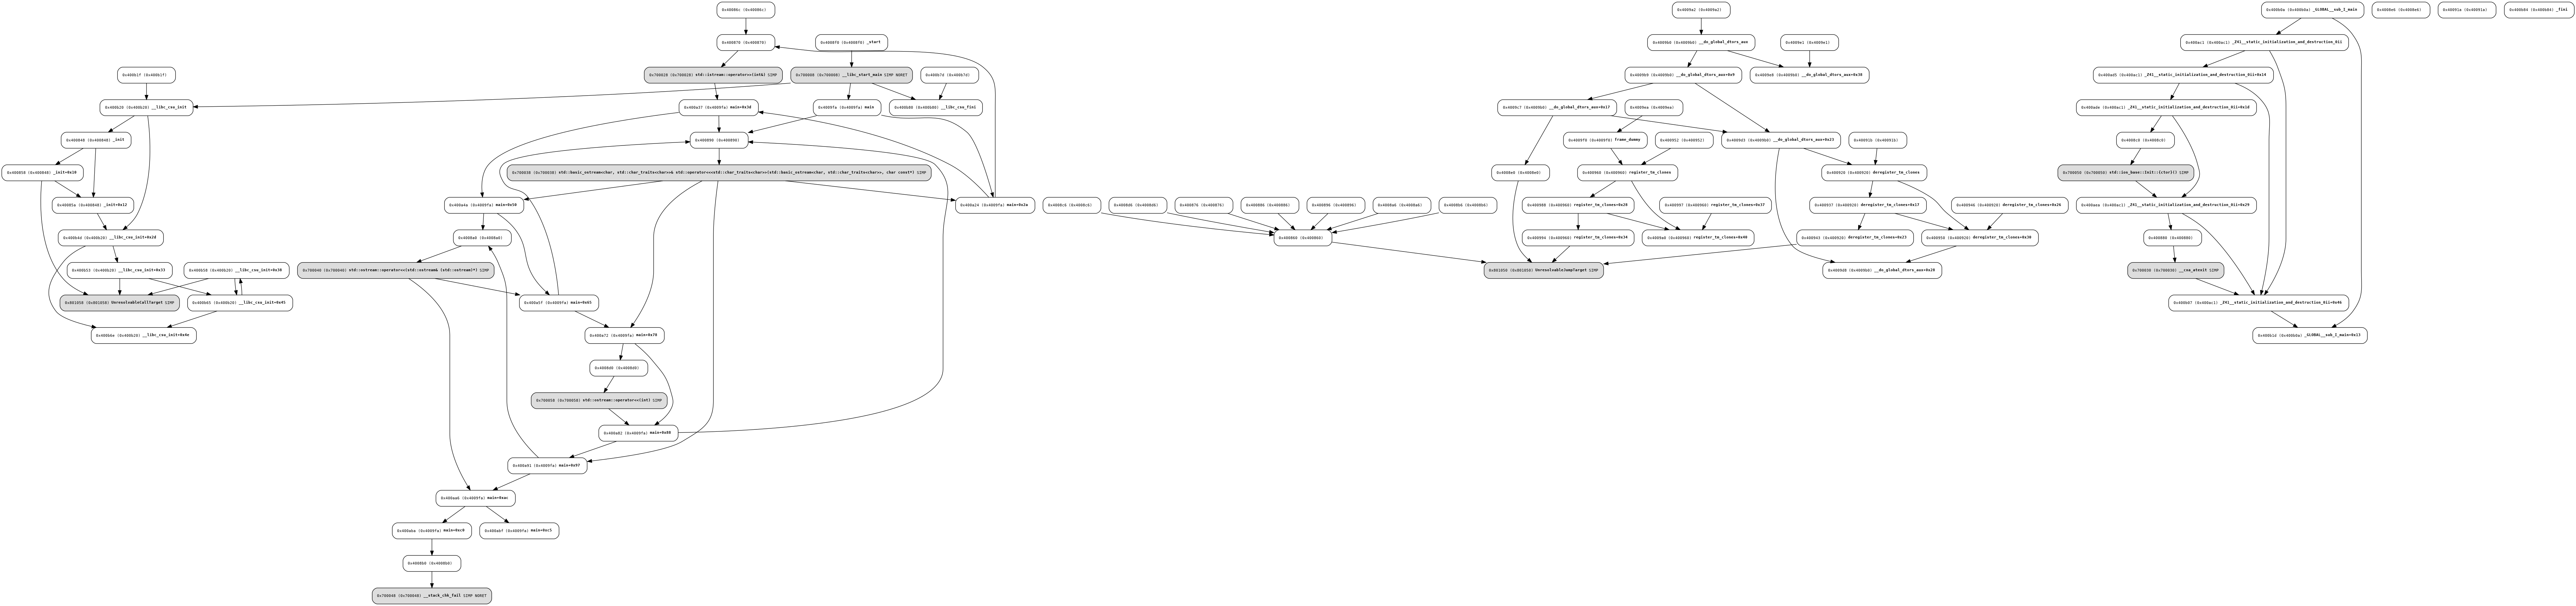

In [32]:
img = Image.open('test.png')
img

### With ```cfg-explore```

In [33]:
%time
cfg_explore(binary='../input/malwarewithangr/task', output='./test.svg')

 26% |#########                          | Elapsed Time: 0:00:00 ETA:   0:00:00

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.82 µs


100% |###################################| Elapsed Time: 0:00:00 Time:  0:00:00


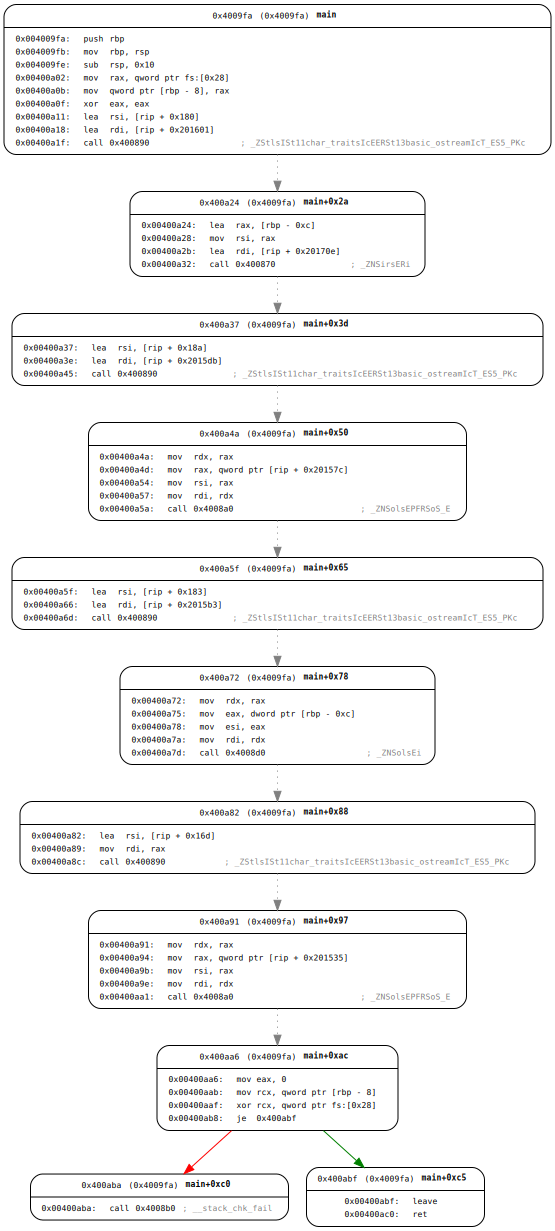

In [34]:
display(SVG('test.svg'))

## Test on larger binary

CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 11.9 µs


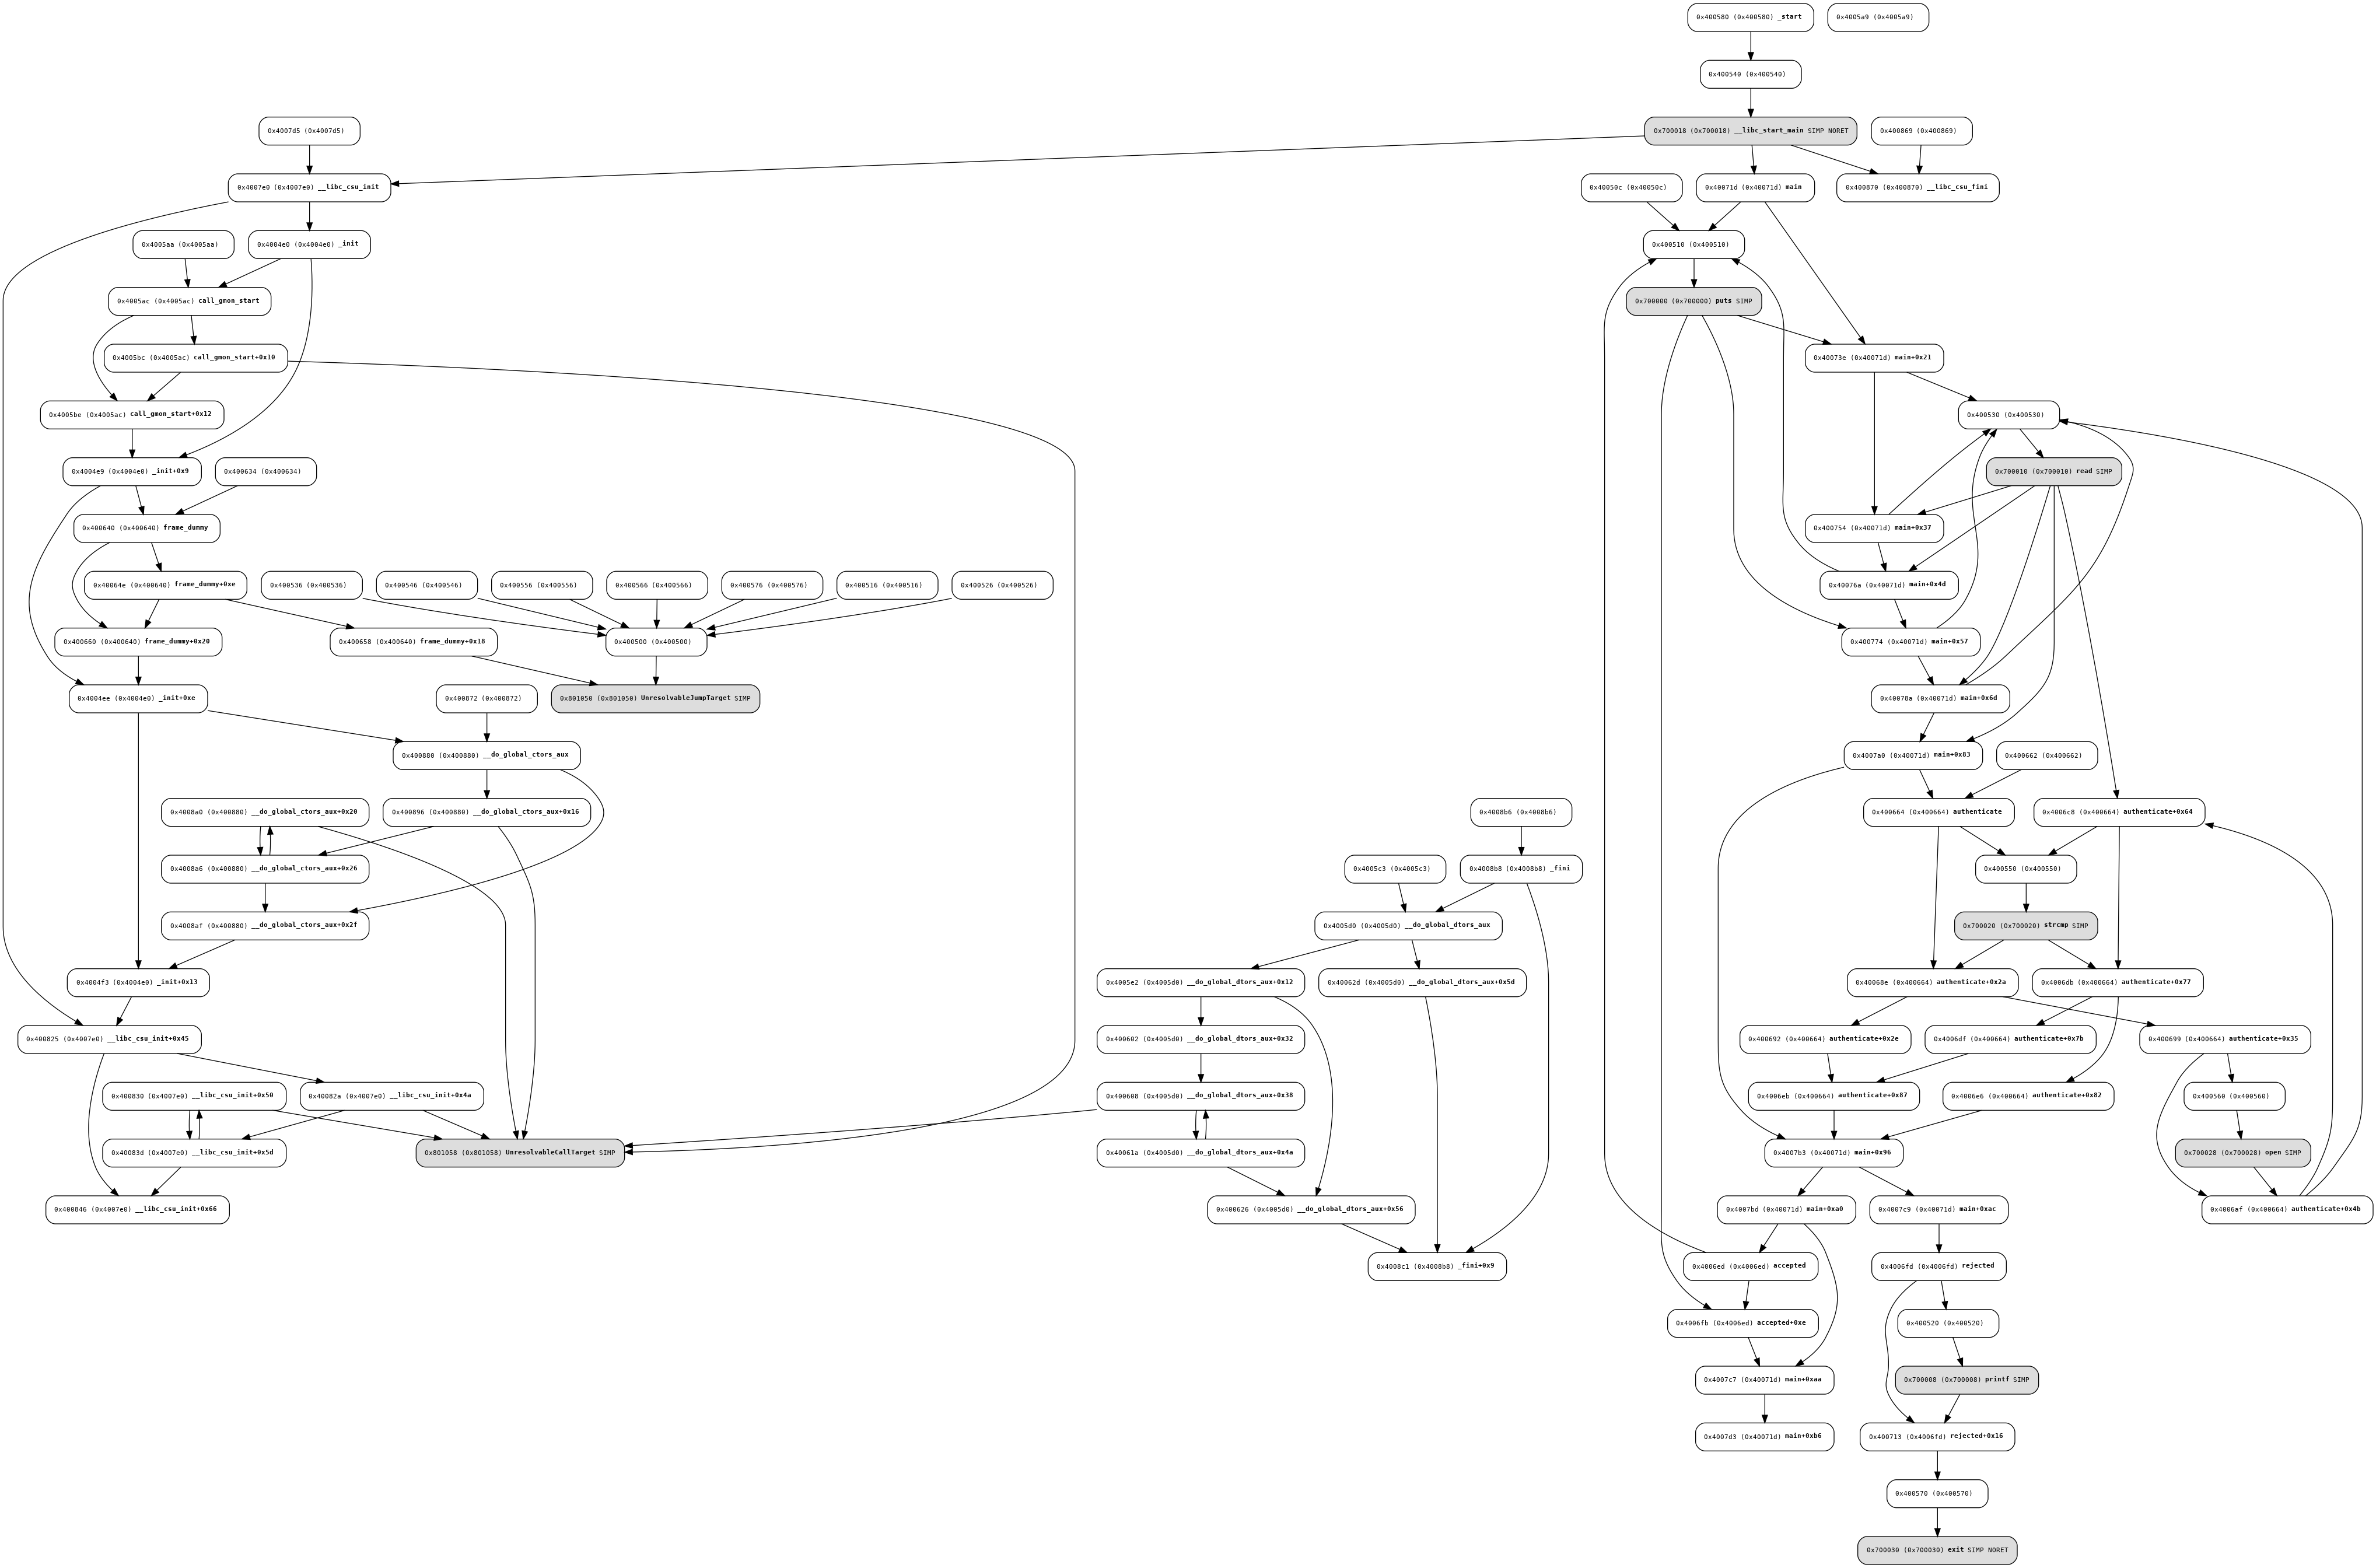

In [35]:
%time
proj = angr.Project('../input/malwarewithangr/fauxware', auto_load_libs=False)
cfg = proj.analyses.CFGFast()
plot_cfg(cfg, 'test-large')
img = Image.open('test-large.png')
img

 76% |##########################         | Elapsed Time: 0:00:00 ETA:   0:00:00

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11.9 µs


100% |###################################| Elapsed Time: 0:00:00 Time:  0:00:00


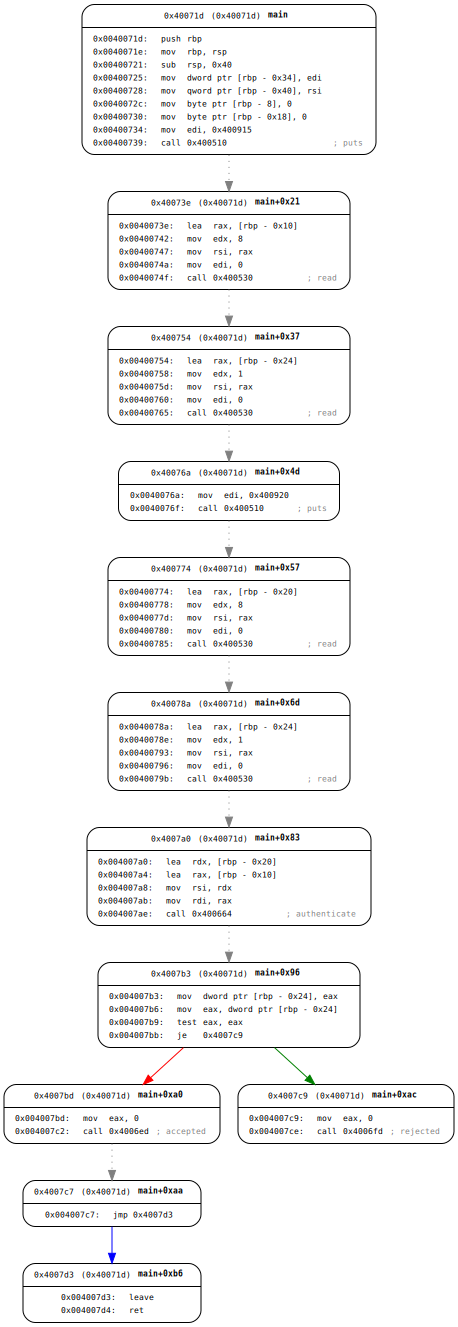

In [36]:
%time
cfg_explore(binary='../input/malwarewithangr/fauxware', output='./test-large.svg')
display(SVG('test-large.svg'))

So, it is pretty clear that ```angr-utils``` goes into more details for plotting the CFG, while ```cfg-explorer``` makes it easier to understand.